In [20]:
import pandas as pd
import numpy as np
from typing import Optional

# Correcting the DataPrep class again, this time accounting for the trailing spaces in column names
class DataPrep:
    def __init__(self, daily_file: str, monthly_file: str):
        self.daily_df = pd.read_csv(daily_file)
        self.monthly_df = pd.read_csv(monthly_file)
        self.month_col = 'MONTH'
        self.prep_monthly_data()
        self.latest_df = None

    def prep_monthly_data(self) -> Optional[pd.DataFrame]:
        # Remove trailing spaces from column names
        self.monthly_df.columns = self.monthly_df.columns.str.strip()
        self.monthly_df[self.month_col] = pd.to_datetime(self.monthly_df['MONTH'], format='%b-%y')

    def prepare_data(self) -> Optional[pd.DataFrame]:
        month_col = self.month_col
        # Remove trailing spaces from column names
        self.daily_df.columns = self.daily_df.columns.str.strip()
        self.daily_df['Date'] = pd.to_datetime(self.daily_df['Date'], format='%d-%b-%Y')
        
        # Create 'MONTH (Closing Values)' in a copy of daily_df
        daily_monthly_df = self.daily_df.copy()[['Date', 'Close']]
        daily_monthly_df[month_col] = daily_monthly_df['Date'].dt.to_period('M').dt.strftime('%b-%y')
        daily_monthly_df[month_col] = pd.to_datetime(daily_monthly_df[month_col], format='%b-%y')
        daily_monthly_df = daily_monthly_df.drop('Date', axis=1) # Drop 'Date' column
        # Group by 'MONTH (Closing Values)' and take the last record
        daily_monthly_df = daily_monthly_df.groupby(month_col).last().reset_index()
        
        # Sort by 'MONTH (Closing Values)', oldest to newest
        daily_monthly_df = daily_monthly_df.sort_values(month_col, ascending=True)

        # print(daily_monthly_df[month_col].value_counts())
        # for MONTH which are present in both daily_monthly_df and monthly_df, drop the values in monthly_df
        self.monthly_df = self.monthly_df[~self.monthly_df[month_col].isin(daily_monthly_df[month_col])]
        self.latest_df = pd.concat([daily_monthly_df, self.monthly_df])
        # Sort by 'Date', oldest to newest
        self.latest_df = self.latest_df.sort_values(month_col, ascending=True)
        print(self.latest_df.head())
        print(self.latest_df.tail())
        print(self.latest_df[month_col].nunique())
        
        # Convert Close to float, strip commas and round to 2 decimal places
        self.latest_df['Close'] = self.latest_df['Close'].astype(str).str.replace(',', '').astype(float).round(2)
        return self.latest_df

# Prepare the data
data_prep = DataPrep(daily_file = "../data/NIFTY200 MOMENTUM 30-9-09-2022-to-9-09-2023.csv", monthly_file = "../data/MomentumMonthly.csv")
latest_df = data_prep.prepare_data()

latest_df['MONTH'] = latest_df['MONTH'].dt.strftime('%b-%y')
latest_df.to_csv("../data/MomentumMonthly.csv", index=False)

latest_df['MOMENTUM_PERCENT_CHANGE'] = latest_df['Close'].pct_change(periods=3) * 100
latest_df['MOMENTUM_PERCENT_CHANGE'] = latest_df['MOMENTUM_PERCENT_CHANGE'].round(2)

       MONTH    Close
0 2005-12-01  1420.49
1 2006-01-01  1557.13
2 2006-02-01  1605.73
3 2006-03-01  1797.03
4 2006-04-01  1920.62
        MONTH     Close
8  2023-05-01  20459.90
9  2023-06-01  21312.90
10 2023-07-01  22275.85
11 2023-08-01  22211.65
12 2023-09-01  23085.30
214


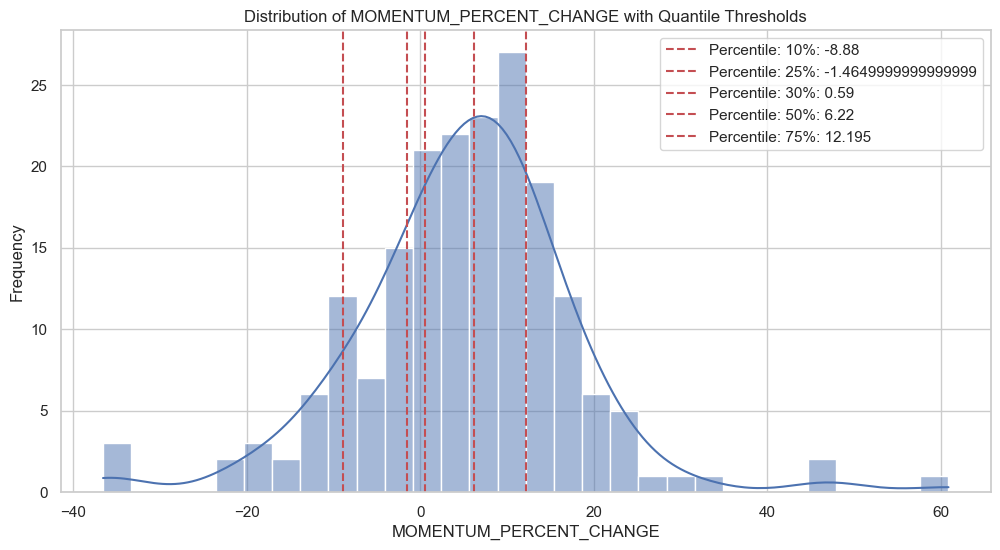

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out NaN values from the MOMENTUM_PERCENT_CHANGE column for plotting
filtered_momentum_percent_change = latest_df['MOMENTUM_PERCENT_CHANGE'].dropna()[:-20]

# Plot the distribution of the MOMENTUM_PERCENT_CHANGE column
quantiles = [0.1, 0.25, 0.30, 0.5, 0.75]

# Calculate the quantile values from the 'MOMENTUM_PERCENT_CHANGE' column
quantile_values = filtered_momentum_percent_change.quantile(quantiles).tolist()

# Plot the distribution with the quantile thresholds
plt.figure(figsize=(12, 6))
sns.histplot(filtered_momentum_percent_change, bins=30, kde=True)
for idx, q_value in enumerate(quantile_values):
    plt.axvline(x=q_value, color='r', linestyle='--', label=f'Percentile: {quantiles[idx]*100:.0f}%: {q_value}')

plt.title('Distribution of MOMENTUM_PERCENT_CHANGE with Quantile Thresholds')
plt.xlabel('MOMENTUM_PERCENT_CHANGE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [22]:
latest_df[latest_df['MOMENTUM_PERCENT_CHANGE'].isna()]

,MONTH,Close,MOMENTUM_PERCENT_CHANGE
0,Dec-05,1420.49,NaN
1,Jan-06,1557.13,NaN
2,Feb-06,1605.73,NaN


In [81]:
def switch(latest_df, col_name: str = "SWITCH_DYNAMIC", initial_value: str = 'MOMENTUM', to_cash: float = -1.96, to_momentum: float = 12.0) -> pd.DataFrame:
    df = latest_df.copy()
    # Remove any rows where all values are NaN before proceeding
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    switch_list = []
    # Loop through the DataFrame to populate the SWITCH_DYNAMIC column based on the thresholds
    for idx in range(len(df)):
        if idx == 0:
            switch_list.append(initial_value)
            continue
        prev_row = switch_list[idx-1]
        current_row = df.iloc[idx]
        momentum_change = current_row.get('MOMENTUM_PERCENT_CHANGE')
        if pd.isna(momentum_change):
            switch_value = initial_value
        elif momentum_change < to_cash:
            switch_value = 'CASH'
        elif momentum_change > to_momentum:
            switch_value = 'MOMENTUM'
        else:
            switch_value = prev_row

        switch_list.append(switch_value)
    
    df[col_name] = switch_list
    return df
        
switch_df = switch(latest_df=latest_df, col_name="SWITCH_DYNAMIC", initial_value='MOMENTUM', to_cash=-1.96, to_momentum=12.0)
switch_df = switch(latest_df=switch_df, col_name="SWITCH_DYNAMIC_OPTIMISTIC", initial_value='MOMENTUM', to_cash=0, to_momentum=5.0)
switch_df = switch(latest_df=switch_df, col_name="SWITCH_DYNAMIC_PESSIMISTIC", initial_value='MOMENTUM', to_cash=5, to_momentum=10.0)
switch_df[switch_df.isna().any(axis=1)]

,MONTH,Close,MOMENTUM_PERCENT_CHANGE,SWITCH_DYNAMIC,SWITCH_DYNAMIC_OPTIMISTIC,SWITCH_DYNAMIC_PESSIMISTIC


In [82]:
switch_df['SWITCH_DYNAMIC'].value_counts(), switch_df['SWITCH_DYNAMIC_OPTIMISTIC'].value_counts(), switch_df['SWITCH_DYNAMIC_PESSIMISTIC'].value_counts()

(SWITCH_DYNAMIC
 MOMENTUM    108
 CASH        103
 Name: count, dtype: int64,
 SWITCH_DYNAMIC_OPTIMISTIC
 MOMENTUM    131
 CASH         80
 Name: count, dtype: int64,
 SWITCH_DYNAMIC_PESSIMISTIC
 CASH        128
 MOMENTUM     83
 Name: count, dtype: int64)

In [83]:
switch_df.tail(48)

,MONTH,Close,MOMENTUM_PERCENT_CHANGE,SWITCH_DYNAMIC,SWITCH_DYNAMIC_OPTIMISTIC,SWITCH_DYNAMIC_PESSIMISTIC
163,Oct-19,13162.14,7.54,CASH,MOMENTUM,CASH
164,Nov-19,13336.77,9.71,CASH,MOMENTUM,CASH
165,Dec-19,13685.95,6.52,CASH,MOMENTUM,CASH
166,Jan-20,13995.19,6.33,CASH,MOMENTUM,CASH
167,Feb-20,13598.81,1.96,CASH,MOMENTUM,CASH
168,Mar-20,11002.27,-19.61,CASH,CASH,CASH
169,Apr-20,12533.46,-10.44,CASH,CASH,CASH
170,May-20,12141.83,-10.71,CASH,CASH,CASH
171,Jun-20,12952.24,17.72,MOMENTUM,MOMENTUM,MOMENTUM
172,Jul-20,13804.99,10.15,MOMENTUM,MOMENTUM,MOMENTUM


In [84]:
def add_amount_based_on_strategy(df: pd.DataFrame, strategy: str, initial_amount: float = 1000.0, momentum_col: str = 'Close') -> pd.DataFrame:
    """
    Adds an 'AMOUNT_<STRATEGY>' column to the DataFrame based on the given cash-only strategy.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to which the new column will be added.
        strategy (str): The strategy column based on which the amount will be calculated.
        initial_amount (float): The initial amount of investment. Default is 1000 INR.
        momentum_col (str): The column representing the momentum TRI. Default is 'NIFTY 200 MOMENTUM 30 TRI'.
    
    Returns:
        pd.DataFrame: DataFrame with the new 'AMOUNT_<STRATEGY>' column added.
    """
    df_copy = df.copy()
    amount_list = [initial_amount]  # Start with the initial amount
    amount_col = f'AMOUNT_{strategy}'
    
    for idx in range(1, len(df)):
        prev_row = df_copy.iloc[idx - 1]
        current_row = df_copy.iloc[idx]
        
        if current_row[strategy] == "MOMENTUM":
            current_amount = amount_list[-1] * (current_row[momentum_col] / prev_row[momentum_col])
        else:
            current_amount = amount_list[-1]  # In CASH, just copy the previous value
        
        amount_list.append(current_amount)
    
    df_copy[amount_col] = amount_list  # No more slicing, now the lengths should match
    
    return df_copy

amount_df = add_amount_based_on_strategy(switch_df, strategy='SWITCH_DYNAMIC_OPTIMISTIC', initial_amount=1000.0)
amount_df = add_amount_based_on_strategy(amount_df, strategy='SWITCH_DYNAMIC', initial_amount=1000.0)
amount_df = add_amount_based_on_strategy(amount_df, strategy='SWITCH_DYNAMIC_PESSIMISTIC', initial_amount=1000.0)

# round the values to 2 decimal places
amount_df['AMOUNT_SWITCH_DYNAMIC'] = amount_df['AMOUNT_SWITCH_DYNAMIC'].round(2)
amount_df['AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC'] = amount_df['AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC'].round(2)
amount_df

,MONTH,Close,MOMENTUM_PERCENT_CHANGE,SWITCH_DYNAMIC,SWITCH_DYNAMIC_OPTIMISTIC,SWITCH_DYNAMIC_PESSIMISTIC,AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC,AMOUNT_SWITCH_DYNAMIC,AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC
0,Mar-06,1797.03,26.51,MOMENTUM,MOMENTUM,MOMENTUM,1000.00,1000.00,1000.000000
1,Apr-06,1920.62,23.34,MOMENTUM,MOMENTUM,MOMENTUM,1068.77,1068.77,1068.774589
2,May-06,1594.60,-0.69,MOMENTUM,CASH,CASH,1068.77,887.35,1068.774589
3,Jun-06,1585.17,-11.79,CASH,CASH,CASH,1068.77,887.35,1068.774589
4,Jul-06,1585.12,-17.47,CASH,CASH,CASH,1068.77,887.35,1068.774589
...,...,...,...,...,...,...,...,...,...
206,May-23,20459.90,14.36,MOMENTUM,MOMENTUM,MOMENTUM,52275.19,28236.32,27587.896243
207,Jun-23,21312.90,16.74,MOMENTUM,MOMENTUM,MOMENTUM,54454.61,29413.53,28738.071733
208,Jul-23,22275.85,15.32,MOMENTUM,MOMENTUM,MOMENTUM,56914.95,30742.48,30036.502551
209,Aug-23,22211.65,8.56,MOMENTUM,MOMENTUM,MOMENTUM,56750.92,30653.87,29949.936001


In [85]:
amount_df.to_csv("../data/BackTestAmounts.csv", index=False)

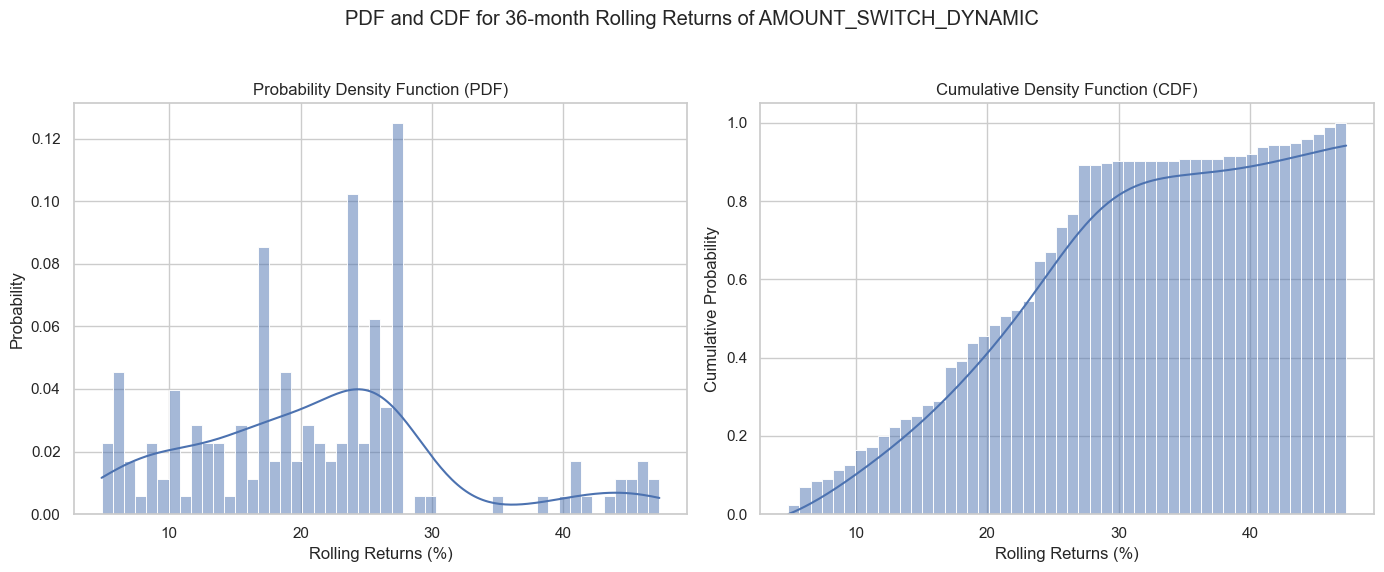

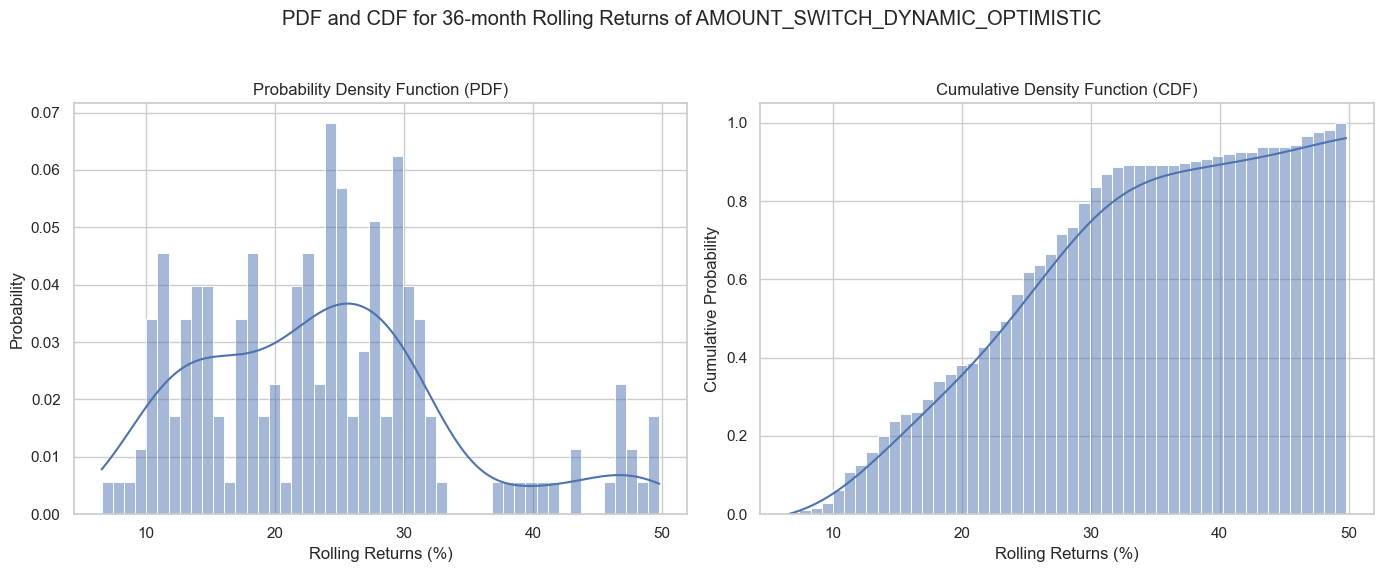

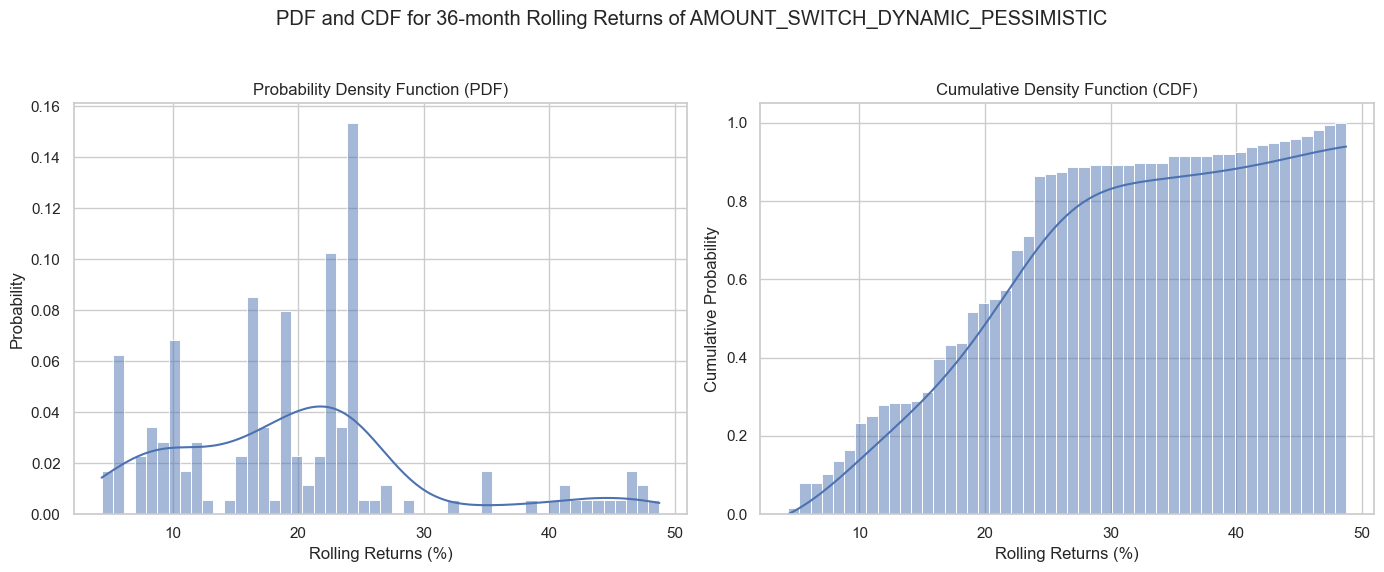

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to calculate rolling returns
def calculate_rolling_returns(df: pd.DataFrame, col_name: str, months: int) -> pd.Series:
    start_values = df[col_name].shift(months - 1)
    end_values = df[col_name]
    cagr = ((end_values / start_values) ** (1 / (months / 12))) - 1
    return cagr * 100  # convert to percentage

def plot_pdf_cdf(df: pd.DataFrame, col_name: str, months: int):
    rolling_returns = calculate_rolling_returns(df, col_name, months).dropna()
    total_rolling_windows = len(rolling_returns)
    sns.set(style="whitegrid")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle(f'PDF and CDF for {months}-month Rolling Returns of {col_name}')

    # PDF Plot
    sns.histplot(rolling_returns, bins=50, kde=True, stat='probability', ax=axes[0])
    axes[0].set_title('Probability Density Function (PDF)')
    axes[0].set_xlabel('Rolling Returns (%)')
    axes[0].set_ylabel('Probability')

    # CDF Plot
    sns.histplot(rolling_returns, bins=50, kde=True, cumulative=True, stat='probability', ax=axes[1])
    axes[1].set_title('Cumulative Density Function (CDF)')
    axes[1].set_xlabel('Rolling Returns (%)')
    axes[1].set_ylabel('Cumulative Probability')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

import warnings
warnings.filterwarnings('ignore')

plot_pdf_cdf(amount_df, 'AMOUNT_SWITCH_DYNAMIC', 36)
plot_pdf_cdf(amount_df, 'AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC', 36)
plot_pdf_cdf(amount_df, 'AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC', 36)

In [87]:
from typing import List


# Helper function to calculate CAGR
def cagr(end_value, start_value, periods):
    return (end_value/start_value)**(1/periods)-1
    
# Function to calculate common backtest statistics
def backtest_stats(df: pd.DataFrame, columns: List[str], rf_rate: float = 0.07) -> pd.DataFrame:
    stats = {}
    for col in columns:
        col_stats = {}
        
        # Calculate CAGR
        cagr_value = cagr(df[col].iloc[-1], df[col].iloc[0], len(df)/12)
        col_stats['CAGR'] = cagr_value

        # Calculate annualized risk
        df['returns'] = df[col].pct_change().dropna()
        annual_risk = df['returns'].std() * np.sqrt(12)
        col_stats['Annualized Risk'] = annual_risk

        # Sharpe Ratio
        sharpe_ratio = (cagr_value - rf_rate) / annual_risk
        col_stats['Sharpe Ratio'] = sharpe_ratio

        # Max Drawdown
        df['cum_return'] = (1 + df['returns']).cumprod()
        df['cum_roll_max'] = df['cum_return'].cummax()
        df['drawdown'] = df['cum_roll_max'] - df['cum_return']
        df['drawdown_pct'] = df['drawdown'] / df['cum_roll_max']
        max_drawdown = df['drawdown_pct'].max()
        col_stats['Max Drawdown'] = max_drawdown

        # Sortino Ratio
        df['downside_returns'] = 0
        target = 0
        mask = df['returns'] < target
        df.loc[mask, 'downside_returns'] = df['returns']**2
        expected_return = df['returns'].mean()
        downside_std = np.sqrt(df['downside_returns'].mean())
        sortino_ratio = (expected_return - rf_rate) / downside_std
        col_stats['Sortino Ratio'] = sortino_ratio

        # Calmar Ratio
        calmar_ratio = cagr_value / max_drawdown
        col_stats['Calmar Ratio'] = calmar_ratio

        stats[col] = col_stats

    return pd.DataFrame(stats)


backtest_stats(amount_df, columns=['AMOUNT_SWITCH_DYNAMIC', 'AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC', 'AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC'])

,AMOUNT_SWITCH_DYNAMIC,AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC,AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC
CAGR,0.217565,0.260970,0.215958
Annualized Risk,0.138733,0.138356,0.126665
Sharpe Ratio,1.063665,1.380278,1.152313
Max Drawdown,0.169747,0.082994,0.041487
Sortino Ratio,-3.697791,-4.722781,-10.550263
Calmar Ratio,1.281708,3.144448,5.205408
